# Debugging loyfer

In [1]:
# #############################
# #   Experiment parameters   #
# #############################
# ROOT_DIR = '/analysis/gh-msun/'
# PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
# EXPERIMENT = 'primary_immune'
# TITRATING_CELLTYPE = 'Blueprint-B'
# TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
# BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
# N_REPLICATES = 2 # number of replicates for each mixture
# SEED = 888 # need to change for different experiment
# TOTAL_READS_TO_SAMPLE = 1000000

# # make sure the orders of the two list match
# CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
# ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# # TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
# #                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
# TITRATION_LIST=[0.2, 0.15]

# # proportion of cells in real whole blood (sum to 1)
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          'Blueprint-CD4':0.16,
#                          'Blueprint-CD8':0.07,
#                          'Blueprint-NK':0.05}
    

In [2]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune_loyfer"
TITRATING_CELLTYPE = "Blood-T"
TITRATING_CELLTYPE_ATLAS = "immune_t"
BACKGROUND = "uniform"
N_REPLICATES = 3
SEED = 83723
TOTAL_READS_TO_SAMPLE = 1000000
# CELLTYPES = ["Blood-B", "Blood-T", "Blood-Mono+Macro"]
# ABRIDGED_NAMES = ["B", "T", "MONOMACRO"]
CELLTYPES = ["Blood-B", "Blood-T", "Blood-Mono+Macro", "Blood-NK"]
ABRIDGED_NAMES = ["B", "T", "MONOMACRO", "NK"]
# CELLTYPES = ['Blueprint-NK', 'Blueprint-B', 'Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-Mono', 'Blueprint-Neutro']
# ABRIDGED_NAMES = ['NK', 'B', 'CD4', 'CD8', 'MONO', 'NEUTRO'] # for directory name
TITRATION_LIST = [0.2, 0.01, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blueprint-B": 0.06, "Blueprint-Mono": 0.09, "Blueprint-Neutro": 0.57, "Blueprint-CD4": 0.16, "Blueprint-CD8": 0.07, "Blueprint-NK": 0.05}


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [134]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [6]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blood-T
----------> Loading cell type: Blood-B
----------> Loading cell type: Blood-Mono+Macro
----------> Loading cell type: Blood-NK
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
--> PROPORTION: [0.01, 0.33, 0.33, 0.33]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
--> PROPORTION: [0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
>>> Complete. <<< 

CPU times: user 54.4 ms, sys: 415 µs, total: 54.8 ms
Wall time: 41.7 s


## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
# cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [11]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
# ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
# ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [14]:
# cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
# cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
# ridxs = (cg_count_hg19==cg_count_hg38)
# ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [15]:
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [16]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377
19,chr1,9147788,9147871,188605,188608,Immune_Broad_Neutro-chr1:9147789-9147871


In [17]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2T_E2667B_E2667MONOMACRO_E2667NK
--------> Computing score matrix for mix0_seed470800
--------> Computing score matrix for mix1_seed966852
--------> Computing score matrix for mix2_seed995826


--> E01T_E33B_E33MONOMACRO_E33NK
--------> Computing score matrix for mix0_seed327469
--------> Computing score matrix for mix1_seed942713
--------> Computing score matrix for mix2_seed899730


--> ET_E3333B_E3333MONOMACRO_E3333NK
--------> Computing score matrix for mix0_seed997493
--------> Computing score matrix for mix1_seed479596
--------> Computing score matrix for mix2_seed228823


>>> Complete. <<< 

CPU times: user 503 ms, sys: 54.2 ms, total: 557 ms
Wall time: 1min 24s


## Deconvolution

In [119]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [120]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/primary_immune_loyfer/Blood-T-uniform//methyl_score/'

In [121]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(285, 10)

In [146]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 153 ms, sys: 68 µs, total: 153 ms
Wall time: 152 ms


In [147]:
deconvolution_nnls[0]

,0,1,2
ref_celltype,,,
immune_b,0.144657,0.145761,0.144756
immune_cd4,0.026261,0.026336,0.021194
immune_cd8,0.074136,0.071720,0.077771
immune_nk,0.112523,0.113360,0.111967
immune_dend_plus_macro_plus_mono,0.086423,0.088962,0.084554
immune_eosi,0.002205,0.002097,0.002082
immune_neutro,0.006217,0.004769,0.005188
immune_eryth,0.000000,0.000000,0.000000
immune_mega,0.001947,0.000904,0.002516


In [148]:
deconvolution_nnls[1]

,0,1,2
ref_celltype,,,
immune_b,0.178379,0.177815,0.177514
immune_cd4,0.000000,0.000000,0.000000
immune_cd8,0.011748,0.010084,0.011430
immune_nk,0.135201,0.136542,0.135667
immune_dend_plus_macro_plus_mono,0.110564,0.105358,0.108170
immune_eosi,0.001851,0.002104,0.001155
immune_neutro,0.006590,0.008962,0.007586
immune_eryth,0.000000,0.000000,0.000000
immune_mega,0.002983,0.001598,0.001478


In [149]:
deconvolution_nnls[2]

,0,1,2
ref_celltype,,,
immune_b,0.178828,0.179275,0.175559
immune_cd4,0.000000,0.000000,0.000000
immune_cd8,0.006846,0.007276,0.009268
immune_nk,0.137199,0.134385,0.137188
immune_dend_plus_macro_plus_mono,0.111992,0.112896,0.110089
immune_eosi,0.001974,0.001347,0.000938
immune_neutro,0.006413,0.008301,0.009599
immune_eryth,0.000000,0.000000,0.000000
immune_mega,0.001953,0.000991,0.001664


In [127]:
TITRATING_CELLTYPE_ATLAS

'immune_t'

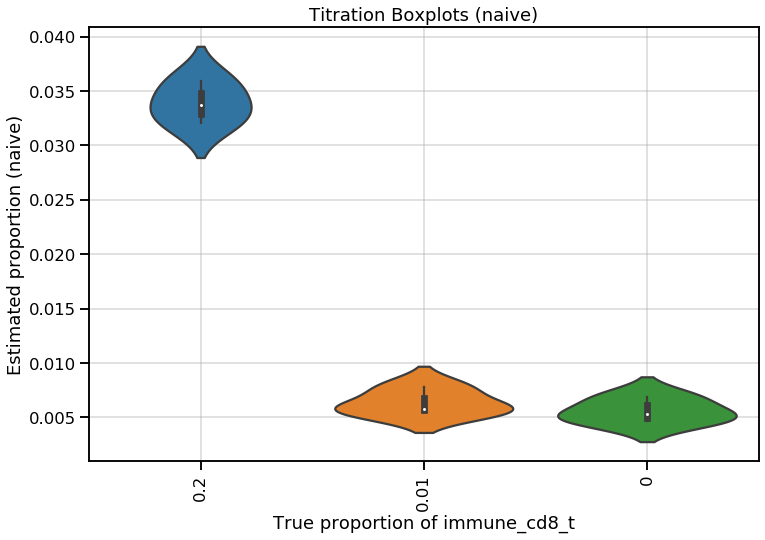

In [154]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type='immune_cd8_t',
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

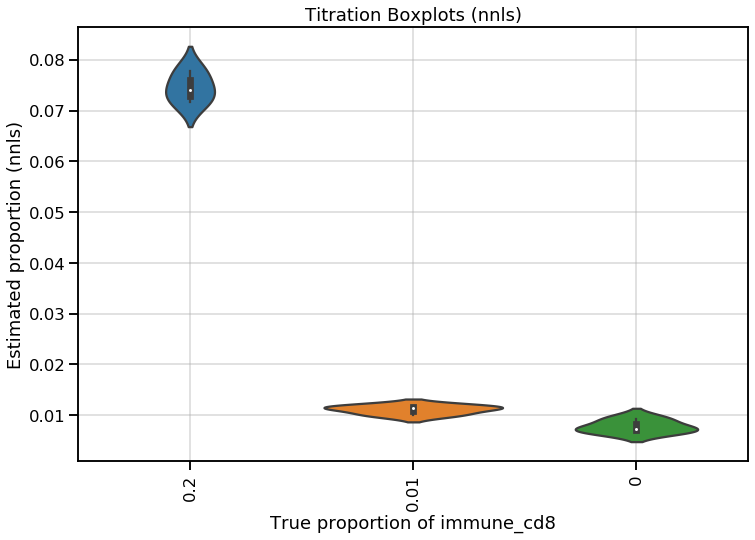

In [155]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_cd8',
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

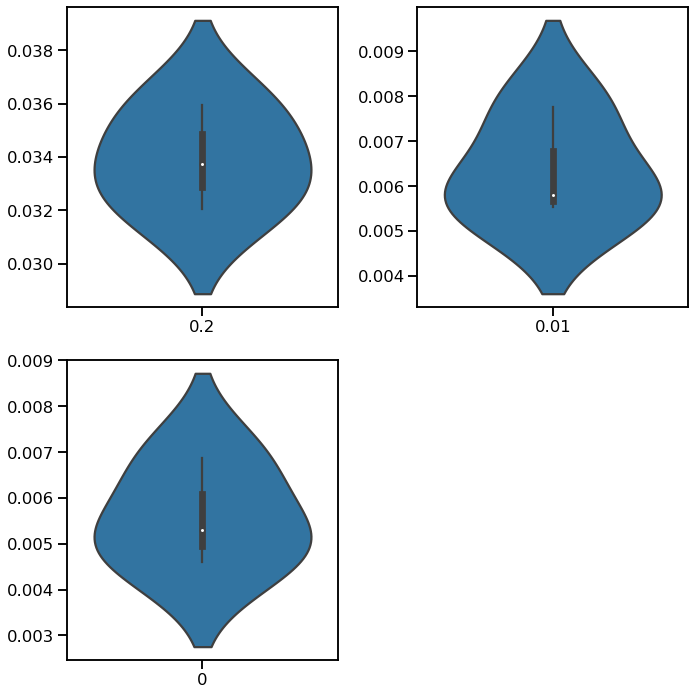

In [156]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type='immune_cd8_t',
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

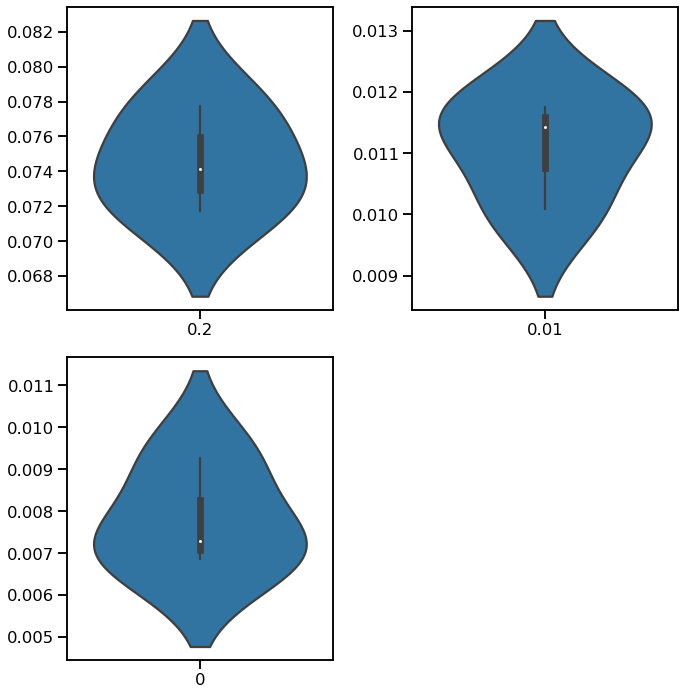

In [157]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_cd8',
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

In [106]:
def score_matrix(parquet_path, result_path, pat_cols, region_df, batch_size, schema, spark, compute_frag_scores_udf, save=False, verbose=False):
    '''
    Function to compute fragment score from one parquet file: 1 parquet file --> 1 score matrix.
    '''
    # Load single parquet file
    pat_df = spark.read.parquet(parquet_path).select(*pat_cols)
    
    scores_df = pat_df\
            .groupby('region_id')\
            .applyInPandas(compute_frag_scores_udf, schema=schema)\
            .toPandas()
    print(scores_df.head())
    
    return(scores_df['frac_alpha_leq_25pct'])
    

In [107]:
def score_matrix(parquet_path, result_path, pat_cols, region_df, batch_size, schema, spark, compute_frag_scores_udf, save=False, verbose=False):
    '''
    Function to compute fragment score from one parquet file: 1 parquet file --> 1 score matrix.
    '''
    # Load single parquet file
    pat_df = spark.read.parquet(parquet_path).select(*pat_cols)
    
    scores_df = pat_df\
            .groupby('region_id')\
            .applyInPandas(compute_frag_scores_udf, schema=schema)\
            .toPandas()
    
    return(scores_df[['region_id', 'frac_alpha_leq_25pct']])
    
    # if save:
    #     file_name = os.path.basename(parquet_path)
    #     file_name_without_ext = os.path.splitext(file_name)[0]
    #     save_path = result_path + '/' + file_name_without_ext + '.tsv.gz'
    #     scores_df.to_csv(save_path, sep='\t', index=False)

In [108]:
%%time
CELLTYPES = ["Blood-B", "Blood-T", "Blood-Mono+Macro", "Blood-NK"]
#CELLTYPES = ["Blueprint-B", "Blueprint-CD4", "Blueprint-NK", "Blueprint-Neutro"]
scores = []

for celltype in CELLTYPES:
    parquet_path = PROJECT_DIR + f'output/mixture_source/collapsed_reads_{celltype}'
    score = score_matrix(parquet_path=parquet_path, 
                   result_path = RESULT_PATH, 
                   pat_cols = PAT_COLS, 
                   region_df = region_df, 
                   batch_size = 20, 
                   schema = RETURN_SCHEMA, 
                   spark=spark,
                   compute_frag_scores_udf=compute_frag_scores_udf,
                   save=True, 
                   verbose=True)
    scores.append(score)



CPU times: user 99.7 ms, sys: 39.4 ms, total: 139 ms
Wall time: 56.7 s


In [109]:
# matching regions

common_names = set(scores[0]['region_id'])  # start with names in first df
for df in scores[1:]:  # for each remaining df
    common_names = common_names.intersection(set(df['region_id']))

# Keep only the rows with 'name' in 'common_names'
df_list = [df[df['region_id'].isin(common_names)] for df in scores]

region_names = df_list[0]['region_id']

# sort
df_list = [df.sort_values('region_id') for df in df_list]

# drop region id
for df in df_list:
    df.drop('region_id', axis=1, inplace=True)
   
# resetting index
df_list = [df.reset_index(drop=True) for df in df_list]

In [110]:
df_list[0]

,frac_alpha_leq_25pct
0,0.00000
1,0.00000
2,0.00000
3,0.00000
4,0.00565
...,...
1650,0.00000
1651,0.00000
1652,0.00311
1653,1.00000


In [111]:
df_list[1]

,frac_alpha_leq_25pct
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1650,0.373664
1651,0.119637
1652,0.150905
1653,0.988014


In [112]:
words_to_find = ['immune', 'Immune']  # replace with your words
immune_indicator = region_names.apply(lambda x: 1 if any(word in str(x) for word in words_to_find) else 0).tolist()
sum(immune_indicator)

659

In [113]:
df = pd.concat(df_list, axis=1)
df.columns = CELLTYPES
df.head()

,Blood-B,Blood-T,Blood-Mono+Macro,Blood-NK
0,0.00000,0.0,0.001623,0.0
1,0.00000,0.0,0.000000,0.0
2,0.00000,0.0,0.000000,0.0
3,0.00000,0.0,0.000000,0.0
4,0.00565,0.0,0.001267,0.0


In [114]:
df.shape

(1655, 4)

In [115]:
df['immune_indicator'] = immune_indicator
df.head()

,Blood-B,Blood-T,Blood-Mono+Macro,Blood-NK,immune_indicator
0,0.00000,0.0,0.001623,0.0,0
1,0.00000,0.0,0.000000,0.0,0
2,0.00000,0.0,0.000000,0.0,0
3,0.00000,0.0,0.000000,0.0,0
4,0.00565,0.0,0.001267,0.0,0


In [116]:
# df = pd.concat(scores, axis=1)
# df.columns = CELLTYPES
# df.head()

In [117]:
df.isna().sum()

Blood-B             0
Blood-T             0
Blood-Mono+Macro    0
Blood-NK            0
immune_indicator    0
dtype: int64

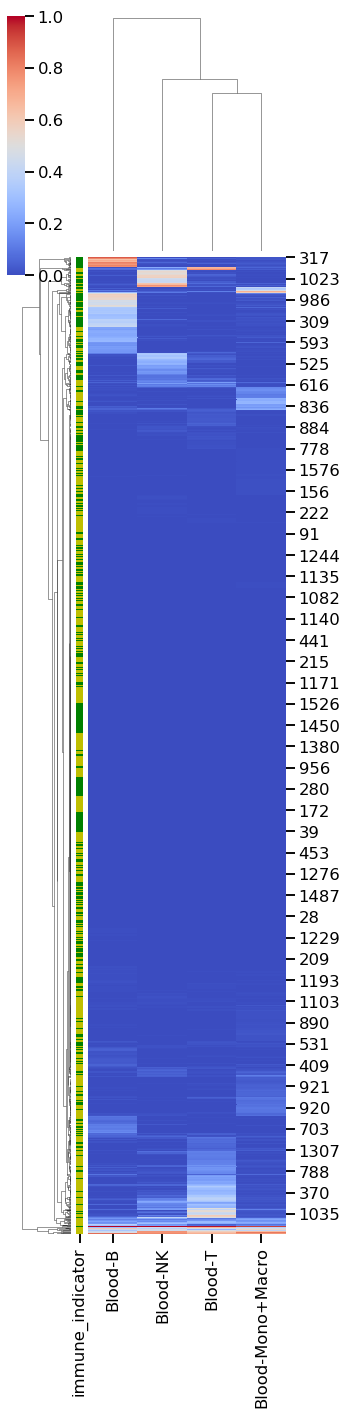

In [118]:
# create a color map: 0 is mapped to red, 1 is mapped to blue
lut = dict(zip(df['immune_indicator'].unique(), "yg"))
row_colors = df['immune_indicator'].map(lut)

df.drop('immune_indicator', axis=1, inplace=True)

# create a clustermap
sns.clustermap(df, row_colors=row_colors, cmap='coolwarm', figsize=(5, 20))
# sns.clustermap(df, cmap='coolwarm', figsize=(10, 8))

plt.show()

In [78]:
# %%time
# parquet_path_b = PROJECT_DIR + 'output/mixture_source/collapsed_reads_Blood-B'
# b_score = score_matrix(parquet_path=parquet_path_b, 
#                result_path = RESULT_PATH, 
#                pat_cols = PAT_COLS, 
#                region_df = region_df, 
#                batch_size = 20, 
#                schema = RETURN_SCHEMA, 
#                spark=spark,
#                compute_frag_scores_udf=compute_frag_scores_udf,
#                save=True, 
#               verbose=True)


In [ ]:
# # compute methyl score for are parquet files
# sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
#                                        result_path = RESULT_PATH, 
#                                        pat_cols = PAT_COLS, 
#                                        region_df = region_df, 
#                                        batch_size = 20, 
#                                        schema = RETURN_SCHEMA, 
#                                        spark=spark,
#                                        compute_frag_scores_udf=compute_frag_scores_udf,
#                                        save=True, 
#                                        verbose=False)